# Finding the "needle in the haystack" galaxies¶
A python excersie notebook written by Lewis McMillan, Summer 2020. This notebook has benifited from examples provided by Rita Tojeiro, and the help of Anne-Marie Weijmans, and Simon Reynolds.

In this notebook you will use data from the Sloan Digital Sky Survey (SDSS), to explore how astronomers interact with "big data", and how they can use various different measurments of galaxies shapes in order to find spiral galaxies, the mergering of multiple galaxies, and other interesting galaxies.

## SDSS and SciServer
As mentioned above, in this notebook we will use data from SDSS, which is is the largest astronmical dataset in the world currently. For eachs nights observing it generates around 200Gb of data. The laptop this notebook was written on has 256Gb of storage space, meaning that I could fit 1 nights observing data on my laptop with some space left over for all the programs I need to analysie the data.

If you are reading this then we assume that you havel alredy followed the instructions to get an account on SciServer, and have uploaded this notebook. In addition to this we assume that you are familiar with basic python, dataframe manipulation, and matplotlib commands. If not please complete Rita Tojeiro's notebook's which cover these topics: link here

In [1]:
# move to correct folder
%cd ..
from pawlikMorphLSST import Image, helpers, pixmap, skyBackground                  # Library for analysing galaxies
print("Galaxy analysis code imported")
# move back to original folder
%cd -

# Import Python libraries to work with SciServer
import SciServer.CasJobs as CasJobs                 # query with CasJobs
import SciServer.SkyServer as SkyServer
print('SciServer libraries imported')

# Import other libraries for use in this notebook.
import numpy as np                                  # standard Python lib for math ops
import pandas as pd                                 # data manipulation package
import matplotlib.pyplot as plt                     # another graphing package
from pathlib import Path                            # manage local files in your Compute containers
from astropy.visualization import ZScaleInterval    # for plotting clear images
from tqdm import tqdm_notebook                      # for a nice progress bar
from concurrent.futures import ProcessPoolExecutor  # for running the code on more than 1 cpu
from IPython.display import clear_output            # allow nice printing
import json
print('Supporting libraries imported')

# Apply some special settings to the imported libraries
# ensure columns get written completely in notebook
pd.set_option('display.max_colwidth', -1)

# for plotting clear images
zscale = ZScaleInterval()

# do *not* show python warnings 
import warnings
warnings.filterwarnings('ignore')
print('Settings applied')

/home/idies/workspace/Storage/0000_0002_7725_5162/persistent/outreach
Galaxy analysis code imported
/home/idies/workspace/Storage/0000_0002_7725_5162/persistent/outreach/notebooks
SciServer libraries imported
Supporting libraries imported
Settings applied


In [3]:
# Find objects in the Sloan Digital Sky Survey's.
#
# Query the Sloan Digital Sky Serveys' NSA catalog of galactical objects.
# For the database schema and documentation see http://skyserver.sdss.org/dr16/en/help/browser/browser.aspx?cmd=description+nsatlas+U#&&history=description+nsatlas+U
#
# This query finds all galaxies in the value added catalogue PawlikMorph and matches this information to the
# MaNGA catalogue in order to get galaxies positions.
# Finally we discard any galaxies that have incomplete measurments
#
# First, store the query in an object called "query"
query="""
select distinct m.objra, m.objdec, p.run, p.rerun, p.camcol, p.field
from dbo.PawlikMorph p
  join dbo.mangaDAPall m
  on m.mangaID = p.mangaid
"""

#Then, query the database. The answer is a table that is being returned to a dataframe that we've named all_gals.
all_gals = CasJobs.executeQuery(query, "dr16")

print("SQL query finished.")
print(f"SQL query returned {len(all_gals.index)} galaxies")

SQL query finished.
SQL query returned 4603 galaxies


In [8]:
# add a column to the dataframe, which contains the path to the image
def makename(df):
    root = "/home/idies/workspace/sdss_das/das2/imaging/"
    df["fname"] = df.apply(lambda row: root + f"{int(row.run)}/{int(row.rerun)}/corr/{int(row.camcol)}/fpC-{int(row.run):06}-r{int(row.camcol)}-{int(row.field):04}.fit.gz", axis=1)
    return df

# add filename column
all_gals = makename(all_gals)

The following three snippets of code should only be run once. If your code crashes during the course of this notebook or you complete this notebook over multiple afternoons skip these three snippets and run the 4th cell down from this.

In [6]:
# This snippet create a list of filenames, and positions that analyseImage requires to run
info = []
for i in range(0, len(all_gals.index)):
    ra, dec = all_gals["objra"].iloc[i], all_gals["objdec"].iloc[i]
    name = all_gals["fname"].iloc[i]
    info.append([name, ra, dec])

In [6]:
def processResult(results):
    processedResults = {"A": [], "As": [], "As90": [], "C": [], "S": [], "g": [], "m20": [], "fname": [], "radec": []}
    for result in results:
        if result[0] != -99:
            processedResults["A"].append(result[0])
            processedResults["As"].append(result[1])
            processedResults["As90"].append(result[2])
            processedResults["C"].append(result[3])
            processedResults["S"].append(result[4])
            processedResults["g"].append(result[5])
            processedResults["m20"].append(result[6])
            processedResults["fname"].append(result[7])
            processedResults["radec"].append((result[8], result[9]))
    return processedResults

In [7]:
cores = 16
results = []
with ProcessPoolExecutor(max_workers=cores) as pool:
    for result in tqdm_notebook(pool.map(helpers.analyseImage, info), total=len(info)):
        results.append(result)
finalResults = processResult(results)
json.dump(finalResults, open("results.json", "w"))

If your code crashes, or this work is completed over more than one afternoon, you can reload the results using the below code in order to save time.

In [2]:
# run this everytime you open the notebook to load in the results
finalResults = json.load(open("results.json"))
# convert dictionary to pandas dataframe
df = pd.DataFrame.from_dict(finalResults)
# print dataframe
df[:10]

,A,As,As90,C,S,g,m20,fname,radec
0,0.049226,0.128583,0.148649,3.278586,0.147236,0.554425,-2.023399,/home/idies/workspace/sdss_das/das2/imaging/1035/40/corr/2/fpC-001035-r2-0144.fit.gz,"[27.475456237793, 13.1266326904297]"
1,0.029085,0.127824,0.172414,3.666046,0.128653,0.645667,-2.195161,/home/idies/workspace/sdss_das/das2/imaging/1035/40/corr/2/fpC-001035-r2-0144.fit.gz,"[27.5298633575439, 13.1103744506836]"
2,0.059730,0.123932,0.170940,3.000422,0.157492,0.580669,-1.842354,/home/idies/workspace/sdss_das/das2/imaging/1035/40/corr/2/fpC-001035-r2-0144.fit.gz,"[27.5653057098389, 13.140772819519]"
3,0.023338,0.215150,0.242483,3.110502,0.388009,0.563187,-1.855298,/home/idies/workspace/sdss_das/das2/imaging/1035/40/corr/2/fpC-001035-r2-0145.fit.gz,"[27.6536617279053, 13.1101999282837]"
4,0.038785,0.164304,0.388999,3.793418,0.154213,0.621341,-2.311551,/home/idies/workspace/sdss_das/das2/imaging/1035/40/corr/2/fpC-001035-r2-0146.fit.gz,"[27.8427829742432, 13.0603351593018]"
5,0.011948,0.140907,0.647154,3.404475,0.590916,0.467828,-2.005495,/home/idies/workspace/sdss_das/das2/imaging/1035/40/corr/1/fpC-001035-r1-0147.fit.gz,"[27.8864421844482, 12.6996002197266]"
6,0.109114,0.167386,0.354185,3.535423,0.208361,0.534193,-0.977005,/home/idies/workspace/sdss_das/das2/imaging/1035/40/corr/3/fpC-001035-r3-0147.fit.gz,"[28.0792255401611, 13.6340560913086]"
7,0.040494,0.077461,0.229446,3.177725,0.104522,0.640461,-2.094511,/home/idies/workspace/sdss_das/das2/imaging/1035/40/corr/2/fpC-001035-r2-0148.fit.gz,"[28.1850471496582, 13.1925506591797]"
8,0.041717,0.149702,0.459753,3.547808,0.342941,0.485550,-1.925784,/home/idies/workspace/sdss_das/das2/imaging/1043/40/corr/5/fpC-001043-r5-0185.fit.gz,"[28.3757038116455, 14.570948600769]"
9,0.047903,0.136556,0.172610,3.948916,0.111256,0.617453,-2.172213,/home/idies/workspace/sdss_das/das2/imaging/1043/40/corr/1/fpC-001043-r1-0186.fit.gz,"[28.4430923461914, 12.8804492950439]"


Above show the different rows in the dataframe of results calculated using the full galaxy analysis code
   - A: The asymmetry of galaxy. This calculated on the image of the galaxy by rotating the image by 180 degrees and subtracting it from the original.
   - As: Is the shape asymmetry of the galaxy. This is calculated on the mask of the galaxy by rotating the mask by 180 degrees and subtracting it from the original mask.
   - As90: Is the shape asymmetry of the galaxy at 90 degrees. Again this is calculated on the mask of the galaxy.
   - C: Is the Concentration of light within the galaxy
   - S: Is is the Smoothnees/Clumpiness of the distribution of light in the galaxy.
   - g: Is the Gini index of the galaxy.
   - m20: Is the $2^{nd}$ moment of light of the galaxy
   - fname: is the filesystem location of the image
   - radec: is the location of the galxy in the sky
This notebook will focus on the asymmetry parameters; A, As, and As90.
The next notebook will introduce the other measures of galaxy morphology

# Finding the "needle galaxy" in the universe 
We introduced the asymmetry measures A, and As in the last notebook. To refresh your memory, A is better at finding the asymmery of the internal stuctures of galaxies, where as As is better at finding asymmetry in the overall shape of a galaxy and does not anayse the internal structure at all.

## Exercise
Make sure to use appropriate labels and titles in your plots.
1. Make a scatter plot of A vs As
2. Make histogram plots of A, and As.
3. By inspection of the above plots, define thresholds for A, and As in which the majortiy of points fall under. Then split the dataset into major and minority subsets. Plot these subsets as you did in Q1, but explicitly colouring the different subsets. You may want to use the np.where() command or the pandas query command

Text(0, 0.5, 'As')

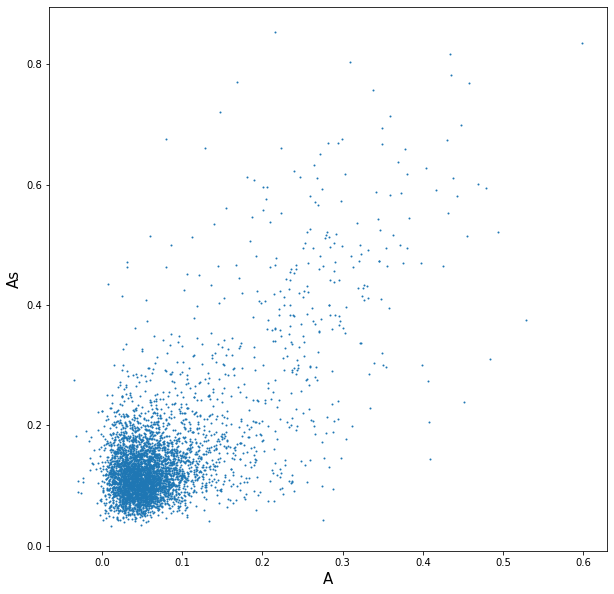

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.scatter(df["A"], df["As"], s=1)
ax.set_xlabel("A", fontsize=15)
ax.set_ylabel("As", fontsize=15)

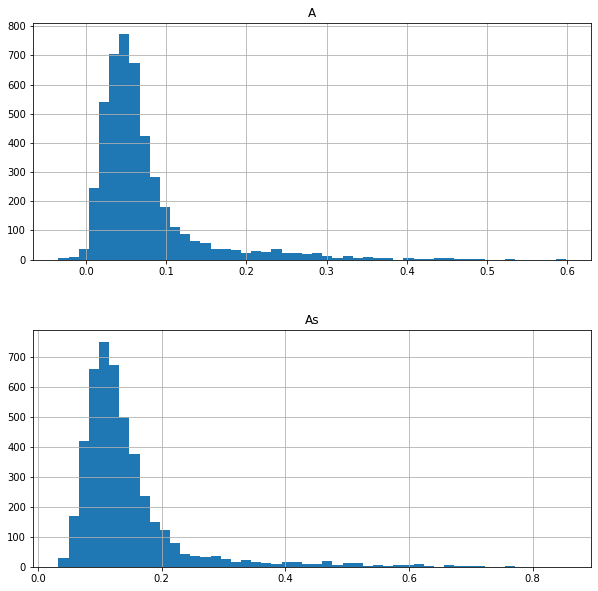

In [4]:
ax = df.hist(bins=50, column=["A", "As"], figsize=(10, 10), layout=(2, 1))

minor subset size:  636
major subset size:  3948


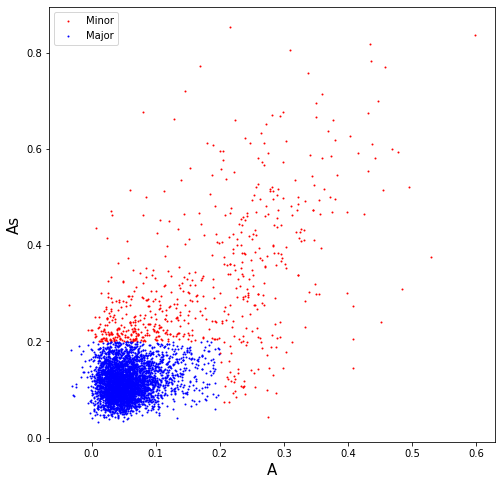

In [5]:
# students answer should be 0.2 <= As <= 2.5, 0.125 <= As <= 0.25

# define threshold as 0.2 for both
minor = df.query("A > 0.2 | As > 0.2")
major = df.query("A <= 0.2 & As <= 0.2")
print("minor subset size: ", len(minor.index))
print("major subset size: ",len(major.index))

fig, axs = plt.subplots(figsize=(8, 8))
axs.scatter(minor["A"], minor["As"], color="red", label="Minor", s=1)
axs.scatter(major["A"], major["As"], color="blue", label="Major", s=1)
axs.set_xlabel("A", fontsize=15)
axs.set_ylabel("As", fontsize=15)
axs.legend()

# Investigating outliers
One common method of ad-hoc analysis Astronomers use is looking at extreme outliers. You may be used at trying to get rid of exteme outliers from the data you've worked with in the past as usuaually these were caused by some source of noise or systematic error. Therefore you would normally run the experiments several more times to reduce the effect of noise or investigate the experiment for sources of systematic error in order to eliminate them.
However, exteme outliers may also indicate some interesting physics! This exercise will investigate these outliers.

## Exercise
    1. Using your knowledge of what A measures, what types of galaxies would you expect to have large A, and
    small A?
    2. Take galaxies with the 5 largest A, and 5 largest As and plot the colour images of them alongside their            masks. You may want to use the below code snippet to help you get started.
    3. Pick some more outliers (no more than 10 maximum) and plot these as before. Write down your rational for picking these outliers. 
    4. For each galaxy you plotted comment on whether it is actually an interesting galaxy. For example is it a          morphological disturbed galaxy, or is just a normal galaxy which has been contaminated by a nearby star or        some other artifact? 
#### Caution some of the plotted masks may be flipped in the horizonbtal or vertical axes!

solution to q1

Student should explain that morphologically messed up galaxies by on large will have larger A than ellpitcal or spherical galaxies.

In [ ]:
# Code for use in Q2
width, height = 128, 128
scale = 60. / width #  set image scale to that of 1 arcmin
# get colour image
image = SkyServer.getJpegImgCutout(ra=ra, dec=dec, width=width, height=height, scale=scale, dataRelease='DR16')

# get science image
image = Image.readImage("sdss", filename=fname, ra=ra, dec=dec)
sky, skyerr, *rest = skyBackground.skybgr(image)
# get image mask
mask = pixmap.pixelmap(image, sky+skyerr, 3)

TypeError: readImage() got multiple values for argument 'filename'

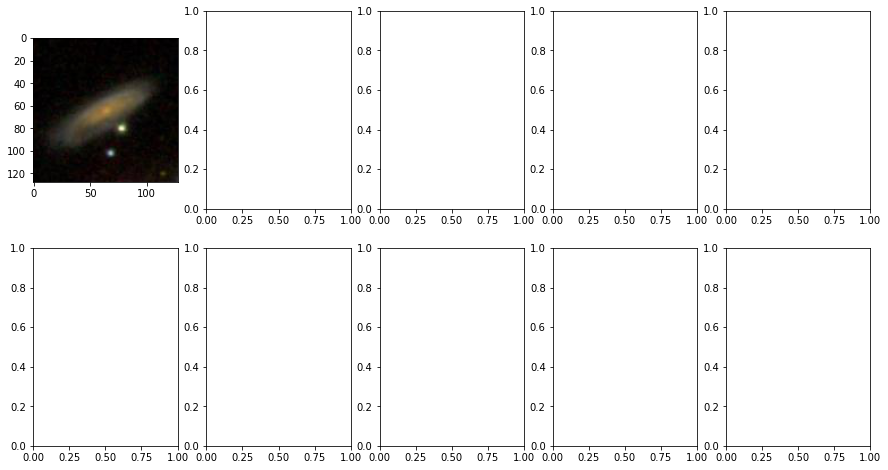

In [7]:
# solution Q2
width, height = 128, 128
scale = 60. / width #  set image scale to that of 1 arcmin
fig, axs = plt.subplots(2, 5, figsize=(15, 8))
axs = axs.ravel()


# for subset of subset, student should target the extreme outliers in either A.
largeA = df.nlargest(5, "A")

for i in range(0, 5):
    ra, dec = largeA["radec"].iloc[i]
    fname = largeA["fname"].iloc[i]

    image = SkyServer.getJpegImgCutout(ra=ra, dec=dec, width=width, height=height, scale=scale, dataRelease='DR16')
    axs[i].imshow(image)
    image = Image.readImage("sdss", filename=fname, ra=ra, dec=dec)
    sky, skyerr, *rest = skyBackground.skybgr(image)
    mask = pixmap.pixelmap(image, sky+skyerr, 3)
    axs[i+5].imshow(mask)

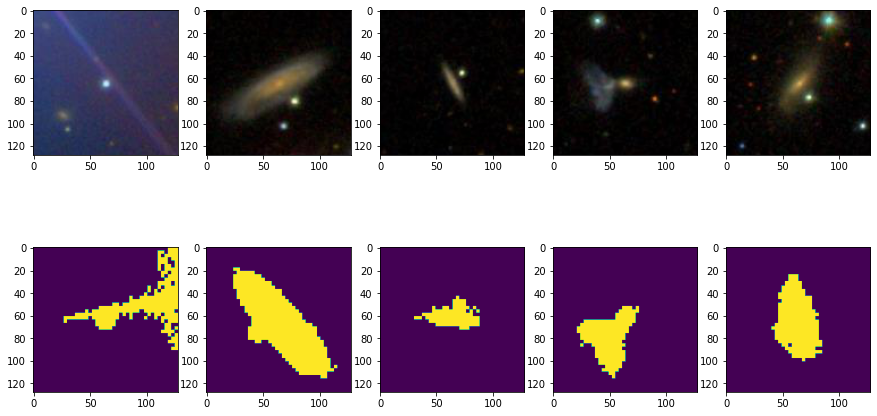

In [34]:
# solution Q2
width, height = 128, 128
scale = 60. / width #  set image scale to that of 1 arcmin
fig, axs = plt.subplots(2, 5, figsize=(15, 8))
axs = axs.ravel()

# for subset of subset, student should target the extreme outliers in either As.
largeAs = df.nlargest(5, "As")

for i in range(0, 5):
    ra, dec = largeAs["radec"].iloc[i]
    fname = largeAs["fname"].iloc[i]

    image = SkyServer.getJpegImgCutout(ra=ra, dec=dec, width=width, height=height, scale=scale, dataRelease='DR16')
    axs[i].imshow(image)
    image = Image.readImage("sdss", filename=fname, ra=ra, dec=dec)
    sky, skyerr, *rest = skyBackground.skybgr(image)
    mask = pixmap.pixelmap(image, sky+skyerr, 3)
    axs[i+5].imshow(mask)

Warning! skyregion smaller than optimal 7875
Warning! skyregion smaller than optimal 16001
Warning! skyregion smaller than optimal 12251
Warning! skyregion smaller than optimal 13547
Warning! skyregion smaller than optimal 15143
Warning! skyregion smaller than optimal 16041
Warning! skyregion smaller than optimal 15861
Warning! skyregion smaller than optimal 16225
Warning! skyregion smaller than optimal 15207


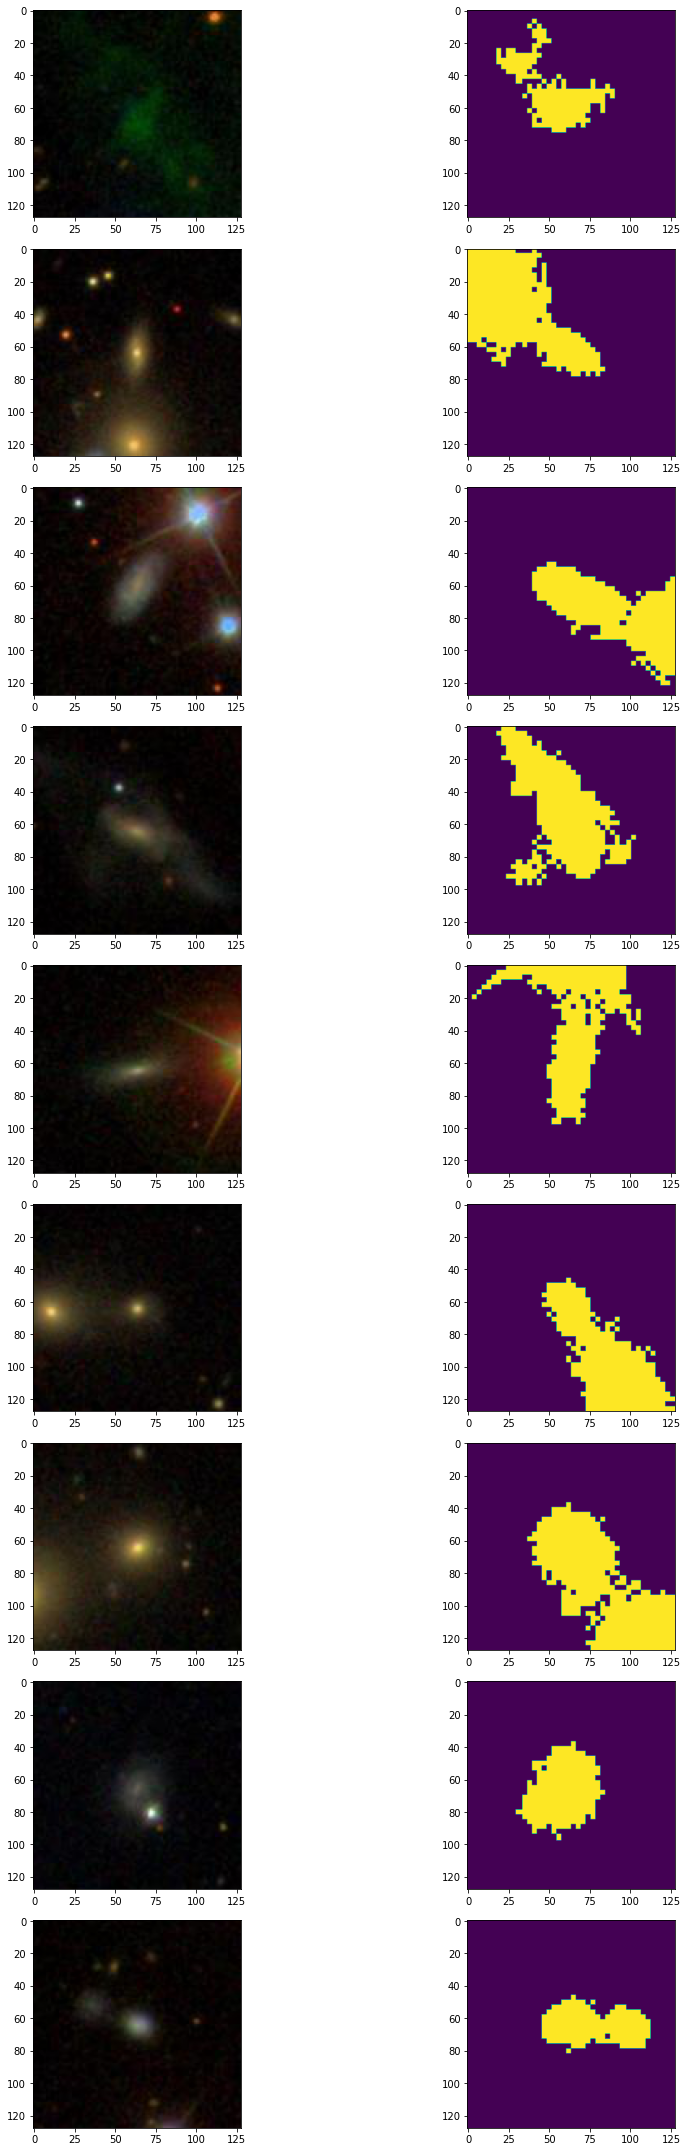

In [9]:
# possible sloution to q3
# student is expected to pick sensible outliers and give good reasoning for why they picked these outliers
# one set of outliers would be to take small A but large As
outliers = np.where((df["A"] < 0.1) & (df["As"] > 0.4))[0]
outliers = df.iloc[outliers]

width, height = 128, 128
scale = 60. / width #  set image scale to that of 1 arcmin
fig, axs = plt.subplots(9, 2, figsize=(15, 30))
axs = axs.ravel()

j = 0
for i in range(0, 9):
    ra, dec = outliers["radec"].iloc[i]
    fname = outliers["fname"].iloc[i]

    image = SkyServer.getJpegImgCutout(ra=ra, dec=dec, width=width, height=height, scale=scale, dataRelease='DR16')
    axs[j].imshow(image)
    image = Image.readImage(filename=fname, ra=ra, dec=dec)
    sky, skyerr, *rest = skyBackground.skybgr(image)
    mask = pixmap.pixelmap(image, sky+skyerr, 3)
    axs[j+1].imshow(mask)
    j += 2
fig.tight_layout()

solution to Q4

Large A
images 1 and 2 are normal galaxies which has been contaminated by a nearby star.
3 and 4 maybe mergers.
5 is contaminated but may be morpholgically disturbed.

Large As
1 is contaminated by a satellite or nearby star. Image is also overexposed.
2,3, and 5 are contaminated by nearby stars.
4 appears to be a merger.

Students own selection
This will depend on the selection made by the student.
For my selections above it apperas that 3,5, and 8 are contaminated but the rest appear morphologically disturbed

## Contamination

By now you should understand that morphologically disturbed galaxies are hard to find! There are a lot of false positives where various external light sources contaminate the glaxies light, tricking our measurments into beleiving that they are asymmetric when its just a bright nearby star in the way. 
We can in princple remove these nearby stars by using a catalog of star locations. However, this tends to remove some pixels that belong to the galaxy, meaning that we are loosing data or worse biasing our calculations!

end this here